Driving Style

1. Method 1: Relative-time dynamic clustering

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import numpy as np

random_seed = 42

file_path = r'D:\UoM\DATA72002\Data\5Yichangjiashi.csv'
df = pd.read_csv(file_path)

df['Global_Time'] = pd.to_datetime(df['Global_Time'], errors='coerce')
df['Time_in_minutes'] = df['Global_Time'].dt.hour * 60 + df['Global_Time'].dt.minute
df = df.dropna(subset=['Time_in_minutes'])

df['Time_Segment'] = df['Time_in_minutes'] // 2
df['Relative_Time'] = df['Time_in_minutes']

features = ['v_Vel', 'v_Acc', 'Space_Headway', 'Time_Headway', 
            'is_abnormal_driving', 'Relative_Time']
scaler = StandardScaler()

cluster_results = []
segment_stats = []

unique_time_segments = np.sort(df['Time_Segment'].unique())

for segment in unique_time_segments:
    seg_df = df[df['Time_Segment'] == segment]
    seg_feat = seg_df[features].dropna()
    
    if len(seg_feat) < 3:
        continue
    
    X_scaled = scaler.fit_transform(seg_feat.values)
    kmeans = KMeans(n_clusters=3, random_state=random_seed, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    df.loc[seg_feat.index, 'driving_style'] = labels
    
    # Calinski-Harabasz
    ch_score = calinski_harabasz_score(X_scaled, labels)
    print(f"Calinski-Harabasz Score for Time Segment {segment}: {ch_score:.2f}")
    
    # Silhouette
    if len(np.unique(labels)) > 1:
        sil_score = silhouette_score(X_scaled, labels)
        print(f"Silhouette Score for Time Segment {segment}: {sil_score:.4f}")
    
    counts = pd.Series(labels).value_counts().sort_index()
    total = counts.sum()
    percents = (counts / total * 100).round(2)
    
    print(f"Segment {segment}: total {total}")
    for style in [0, 1, 2]:
        print(f"  Style {style}: {counts.get(style,0)} sample, percentage {percents.get(style,0.0)}%")
    
    segment_stats.append({
        'Time_Segment': segment,
        'Total': total,
        'CH_Score': ch_score,
        'Silhouette': sil_score if len(np.unique(labels)) > 1 else None,
        'Style0_Count': counts.get(0, 0),
        'Style1_Count': counts.get(1, 0),
        'Style2_Count': counts.get(2, 0),
        'Style0_%': percents.get(0, 0.0),
        'Style1_%': percents.get(1, 0.0),
        'Style2_%': percents.get(2, 0.0),
    })

segment_stats_df = pd.DataFrame(segment_stats)
segment_stats_df.to_csv("segment_stats_clean.csv", index=False)
print("Segment stats saved to segment_stats_clean.csv")


C:\Users\13193\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


Calinski-Harabasz Score for Time Segment 234: 285.46
Silhouette Score for Time Segment 234: 0.3429
Segment 234: total 632
  Style 0: 131 sample, percentage 20.73%
  Style 1: 391 sample, percentage 61.87%
  Style 2: 110 sample, percentage 17.41%
Calinski-Harabasz Score for Time Segment 235: 5189.94
Silhouette Score for Time Segment 235: 0.4331
Segment 235: total 15055
  Style 0: 13126 sample, percentage 87.19%
  Style 1: 1763 sample, percentage 11.71%
  Style 2: 166 sample, percentage 1.1%
Calinski-Harabasz Score for Time Segment 236: 4647.89
Silhouette Score for Time Segment 236: 0.3324
Segment 236: total 15560
  Style 0: 2105 sample, percentage 13.53%
  Style 1: 6946 sample, percentage 44.64%
  Style 2: 6509 sample, percentage 41.83%
Calinski-Harabasz Score for Time Segment 237: 5149.83
Silhouette Score for Time Segment 237: 0.4306
Segment 237: total 16326
  Style 0: 1853 sample, percentage 11.35%
  Style 1: 14442 sample, percentage 88.46%
  Style 2: 31 sample, percentage 0.19%
Calins

In [2]:
# Keep only the features used for clustering
features = ['v_Vel', 'v_Acc', 'Space_Headway', 'Time_Headway', 'is_abnormal_driving', 'Relative_Time']

cluster_means = (
    df.groupby('driving_style')[features]
      .mean()
      .reset_index()
      .rename(columns={'driving_style': 'Cluster'})
)

print("\nFeature means for each cluster (Style 0/1/2):")
print(cluster_means)

# Save to CSV for analysis
cluster_means.to_csv("cluster_feature_means.csv", index=False)
print("Cluster means saved to cluster_feature_means.csv")


Feature means for each cluster (Style 0/1/2):
   Cluster      v_Vel     v_Acc  Space_Headway  Time_Headway  \
0      0.0  31.900419  0.134279      69.954396     89.882855   
1      1.0  27.495134  0.042718      61.459742    118.718492   
2      2.0  32.030078  0.420818      74.770084    584.029114   

   is_abnormal_driving  Relative_Time  
0             0.091882     492.299800  
1             0.088569     496.227087  
2             0.051922     490.627863  
Cluster means saved to cluster_feature_means.csv


In [3]:
# Statistics of the overall proportion of three driving styles 
overall_counts = df['driving_style'].value_counts().sort_index()
overall_total = overall_counts.sum()
overall_percents = (overall_counts / overall_total * 100).round(2)

print("\nOverall driving style distribution:")
for style in [0, 1, 2]:
    print(f"  Style {style}: {overall_counts.get(style,0)} samples, proportion {overall_percents.get(style,0.0)}%")

# Save overall results to CSV
overall_df = pd.DataFrame({
    'Style': [0, 1, 2],
    'Count': [overall_counts.get(0,0), overall_counts.get(1,0), overall_counts.get(2,0)],
    'Percentage': [overall_percents.get(0,0.0), overall_percents.get(1,0.0), overall_percents.get(2,0.0)]
})
overall_df.to_csv("overall_driving_style_proportions.csv", index=False)
print("Overall driving style proportions saved to overall_driving_style_proportions.csv")


Overall driving style distribution:
  Style 0: 211271 samples, proportion 37.43%
  Style 1: 242422 samples, proportion 42.95%
  Style 2: 110704 samples, proportion 19.61%
Overall driving style proportions saved to overall_driving_style_proportions.csv


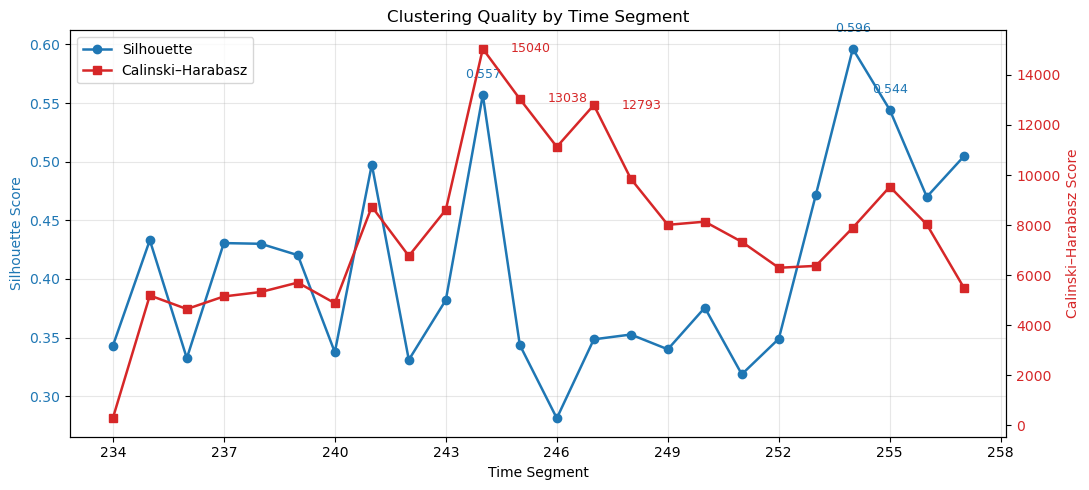

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

data = [
    (234, 0.3429,   285.46),
    (235, 0.4331,  5189.94),
    (236, 0.3324,  4647.89),
    (237, 0.4306,  5149.83),
    (238, 0.4300,  5327.61),
    (239, 0.4203,  5703.77),
    (240, 0.3375,  4881.66),
    (241, 0.4976,  8736.89),
    (242, 0.3310,  6765.90),
    (243, 0.3820,  8610.84),
    (244, 0.5570, 15040.09),
    (245, 0.3437, 13038.14),
    (246, 0.2812, 11125.21),
    (247, 0.3485, 12792.95),
    (248, 0.3526,  9850.98),
    (249, 0.3400,  8009.71),
    (250, 0.3755,  8136.33),
    (251, 0.3187,  7330.84),
    (252, 0.3490,  6295.23),
    (253, 0.4716,  6370.80),
    (254, 0.5963,  7894.28),
    (255, 0.5442,  9530.77),
    (256, 0.4700,  8024.72),
    (257, 0.5045,  5504.76),
]

df = pd.DataFrame(data, columns=['segment', 'silhouette', 'calinski_harabasz'])

# Top-3 high points
topk_sil = df.nlargest(3, 'silhouette')
topk_ch  = df.nlargest(3, 'calinski_harabasz')

# Plot: dual y-axis
fig, ax1 = plt.subplots(figsize=(11, 5))

# Left axis: Silhouette
l1 = ax1.plot(df['segment'], df['silhouette'],
              marker='o', linewidth=1.8, color='tab:blue', label='Silhouette')
ax1.set_xlabel('Time Segment')
ax1.set_ylabel('Silhouette Score', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True, alpha=0.3)

# Right axis: Calinski–Harabasz
ax2 = ax1.twinx()
l2 = ax2.plot(df['segment'], df['calinski_harabasz'],
              marker='s', linewidth=1.8, color='tab:red', label='Calinski–Harabasz')
ax2.set_ylabel('Calinski–Harabasz Score', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

for _, r in topk_sil.iterrows():
    ax1.annotate(f"{r['silhouette']:.3f}",
                 xy=(r['segment'], r['silhouette']),
                 xytext=(0, 10), textcoords='offset points',
                 ha='center', va='bottom', fontsize=9, color='tab:blue')

for _, r in topk_ch.iterrows():
    ax2.annotate(f"{r['calinski_harabasz']:.0f}",
                 xy=(r['segment'], r['calinski_harabasz']),
                 xytext=(20, 0), textcoords='offset points',
                 ha='left', va='center', fontsize=9, color='tab:red')

# Combine legends
lines = l1 + l2
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')

plt.title('Clustering Quality by Time Segment')
plt.tight_layout()
plt.show()

Method 2: Fixed Time Segment Clustering

In [5]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import numpy as np

random_seed = 42

# Load data
file_path = r'D:\UoM\DATA72002\Data\5Yichangjiashi.csv'
df = pd.read_csv(file_path)

# Time segmentation: cut every 1 minute
df['Global_Time'] = pd.to_datetime(df['Global_Time'], errors='coerce')
df['Time_in_minutes'] = df['Global_Time'].dt.hour * 60 + df['Global_Time'].dt.minute
df['Time_Segment'] = df['Time_in_minutes']
df = df.dropna(subset=['Time_in_minutes'])

# Clustering preparation
df['driving_style'] = pd.NA
cluster_results = []
segment_stats = []
unique_time_segments = np.sort(df['Time_Segment'].unique())

features = ['v_Vel', 'v_Acc', 'Space_Headway', 'Time_Headway',
            'is_abnormal_driving', 'Time_in_minutes']
scaler = StandardScaler()

# Cluster each time segment
for segment in unique_time_segments:
    idx = df.index[df['Time_Segment'] == segment]
    seg_feat = df.loc[idx, features].dropna()
    seg_idx = seg_feat.index

    if len(seg_idx) < 3:
        print(f"Segment {segment}: Too few samples ({len(seg_idx)}), skipping clustering.")
        continue

    X_scaled = scaler.fit_transform(seg_feat.values)
    kmeans = KMeans(n_clusters=3, random_state=random_seed, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    df.loc[seg_idx, 'driving_style'] = labels

    # Calculate clustering metrics
    sil, ch = None, None
    if len(np.unique(labels)) >= 2 and len(seg_idx) > len(np.unique(labels)):
        sil = silhouette_score(X_scaled, labels)
        ch = calinski_harabasz_score(X_scaled, labels)

    # Count style distribution
    counts = pd.Series(labels).value_counts().sort_index()
    total = counts.sum()
    percents = (counts / total * 100).round(2)

    print(f"\nSegment {segment}: Silhouette={sil:.4f}, CH={ch:.2f}")
    print(f"Segment {segment}: Total samples {total}")
    for style in [0, 1, 2]:
        print(f"  Style {style}: {counts.get(style,0)} samples, proportion {percents.get(style,0.0)}%")

    # Save results
    segment_stats.append({
        'Time_Segment': segment,
        'Total': total,
        'Silhouette': sil,
        'Calinski_Harabasz': ch,
        'Style0_Count': counts.get(0, 0),
        'Style1_Count': counts.get(1, 0),
        'Style2_Count': counts.get(2, 0),
        'Style0_%': percents.get(0, 0.0),
        'Style1_%': percents.get(1, 0.0),
        'Style2_%': percents.get(2, 0.0)
    })

    cluster_results.append(df.loc[seg_idx, ['Time_in_minutes', 'driving_style']].copy())

# Save clustering label results
if cluster_results:
    all_cluster_results = pd.concat(cluster_results, ignore_index=True)
else:
    all_cluster_results = pd.DataFrame(columns=['Time_in_minutes', 'driving_style'])

all_cluster_results.to_csv('all_time_segment_cluster_results.csv', index=False)
print("\nAll cluster results saved to all_time_segment_cluster_results.csv")

# Save segment statistics
segment_stats_df = pd.DataFrame(segment_stats)
segment_stats_df.to_csv("segment_stats_with_scores.csv", index=False)
print("Segment stats (with Silhouette, CH, proportions) saved to segment_stats_with_scores.csv")

C:\Users\13193\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(



Segment 469: Silhouette=0.3429, CH=285.46
Segment 469: Total samples 632
  Style 0: 131 samples, proportion 20.73%
  Style 1: 391 samples, proportion 61.87%
  Style 2: 110 samples, proportion 17.41%

Segment 470: Silhouette=0.3381, CH=3255.07
Segment 470: Total samples 7235
  Style 0: 977 samples, proportion 13.5%
  Style 1: 4324 samples, proportion 59.77%
  Style 2: 1934 samples, proportion 26.73%

Segment 471: Silhouette=0.5355, CH=3738.94
Segment 471: Total samples 7820
  Style 0: 6868 samples, proportion 87.83%
  Style 1: 166 samples, proportion 2.12%
  Style 2: 786 samples, proportion 10.05%

Segment 472: Silhouette=0.4969, CH=3386.64
Segment 472: Total samples 7446
  Style 0: 937 samples, proportion 12.58%
  Style 1: 18 samples, proportion 0.24%
  Style 2: 6491 samples, proportion 87.17%

Segment 473: Silhouette=0.3590, CH=3570.22
Segment 473: Total samples 8114
  Style 0: 4993 samples, proportion 61.54%
  Style 1: 1168 samples, proportion 14.39%
  Style 2: 1953 samples, proport

In [6]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import numpy as np

random_seed = 42

# Load data
file_path = r'D:\UoM\DATA72002\Data\5Yichangjiashi.csv'
df = pd.read_csv(file_path)

# Time segmentation: cut every 1 minute
df['Global_Time'] = pd.to_datetime(df['Global_Time'], errors='coerce')
df['Time_in_minutes'] = df['Global_Time'].dt.hour * 60 + df['Global_Time'].dt.minute
df['Time_Segment'] = df['Time_in_minutes']
df = df.dropna(subset=['Time_in_minutes'])

# Clustering preparation
df['driving_style'] = pd.NA  
unique_time_segments = np.sort(df['Time_Segment'].unique())

features = ['v_Vel', 'v_Acc', 'Space_Headway', 'Time_Headway',
            'is_abnormal_driving', 'Time_in_minutes']
scaler = StandardScaler()

# Cluster each time segment
for segment in unique_time_segments:
    idx = df.index[df['Time_Segment'] == segment]
    seg_feat = df.loc[idx, features].dropna()
    seg_idx = seg_feat.index

    if len(seg_idx) < 3:
        continue

    # Standardize & cluster
    X_scaled = scaler.fit_transform(seg_feat.values)
    kmeans = KMeans(n_clusters=3, random_state=random_seed, n_init=10)
    labels = kmeans.fit_predict(X_scaled)

    # Write clustering results directly back to df
    df.loc[seg_idx, 'driving_style'] = labels

# Save: overwrite original data with driving_style
save_path = r'D:\UoM\DATA72002\Data\5Yichangjiashi_with_style.csv'
df.to_csv(save_path, index=False)
print(f"Complete results saved to {save_path}, where the driving_style column contains the clustering labels.")

C:\Users\13193\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


Complete results saved to D:\UoM\DATA72002\Data\5Yichangjiashi_with_style.csv, where the driving_style column contains the clustering labels.


In [7]:
# Statistics of overall style distribution
overall_counts = df['driving_style'].value_counts().sort_index()
overall_total = overall_counts.sum()
overall_percents = (overall_counts / overall_total * 100).round(2)

print("\nOverall driving style distribution:")
for style in [0, 1, 2]:
    print(f"  Style {style}: {overall_counts.get(style,0)} samples, proportion {overall_percents.get(style,0.0)}%")

# Save overall distribution
overall_stats = pd.DataFrame({
    "Style": [0, 1, 2],
    "Count": [overall_counts.get(0,0), overall_counts.get(1,0), overall_counts.get(2,0)],
    "Percent": [overall_percents.get(0,0.0), overall_percents.get(1,0.0), overall_percents.get(2,0.0)]
})
overall_stats.to_csv("overall_driving_style_distribution.csv", index=False)
print("Overall driving style distribution saved to overall_driving_style_distribution.csv")

# Statistics of mean features for each cluster
cluster_means = df.groupby('driving_style')[['v_Vel','v_Acc','Space_Headway','Time_Headway','is_abnormal_driving']].mean()
print("\nMean features for each style cluster:")
print(cluster_means)

# Save cluster means
cluster_means.to_csv("cluster_means_features.csv")
print("Cluster mean features saved to cluster_means_features.csv")


Overall driving style distribution:
  Style 0: 354669 samples, proportion 62.84%
  Style 1: 160817 samples, proportion 28.49%
  Style 2: 48911 samples, proportion 8.67%
Overall driving style distribution saved to overall_driving_style_distribution.csv

Mean features for each style cluster:
                   v_Vel     v_Acc  Space_Headway  Time_Headway  \
driving_style                                                     
0              28.889096  0.520008      67.692984     58.709835   
1              31.255718  0.066088      64.606271    334.861893   
2              34.315363 -2.243823      72.733876    771.808606   

               is_abnormal_driving  
driving_style                       
0                         0.029630  
1                         0.106282  
2                         0.389074  
Cluster mean features saved to cluster_means_features.csv


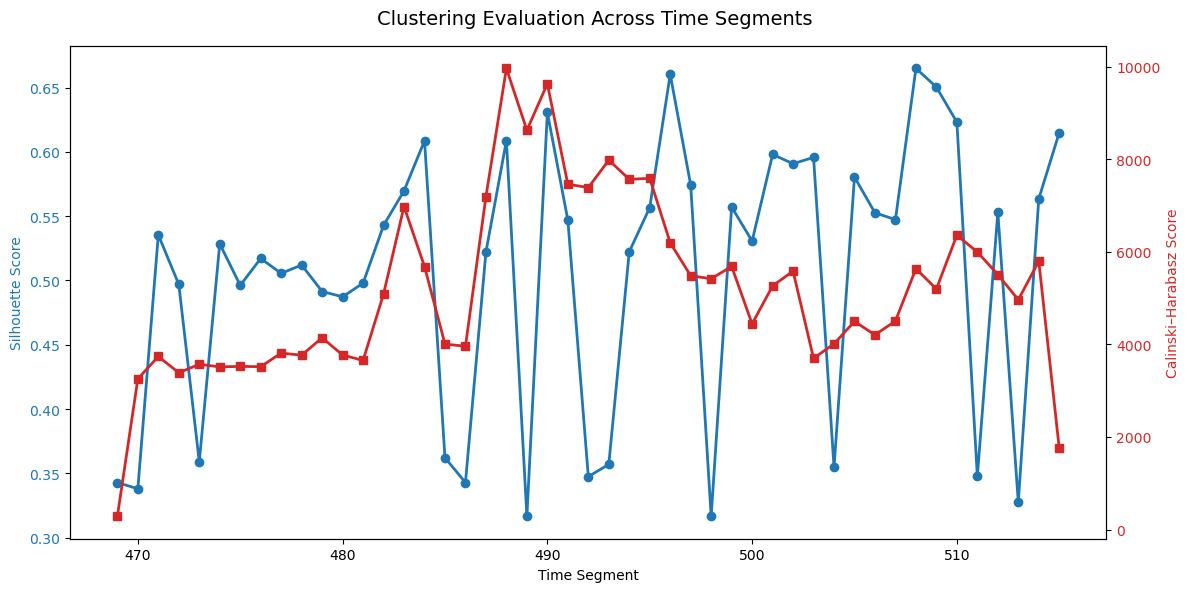

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the saved statistics file
segment_stats_df = pd.read_csv("segment_stats_with_scores.csv")

# Create dual-axis line plot (both with solid lines)
fig, ax1 = plt.subplots(figsize=(12,6))

# Left axis （Silhouette Score）
color = 'tab:blue'
ax1.set_xlabel('Time Segment')
ax1.set_ylabel('Silhouette Score', color=color)
ax1.plot(segment_stats_df['Time_Segment'], segment_stats_df['Silhouette'], 
         marker='o', linestyle='-', linewidth=2, color=color, label='Silhouette Score')
ax1.tick_params(axis='y', labelcolor=color)

# Right axis （Calinski-Harabasz Score）
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Calinski–Harabasz Score', color=color)
ax2.plot(segment_stats_df['Time_Segment'], segment_stats_df['Calinski_Harabasz'], 
         marker='s', linestyle='-', linewidth=2, color=color, label='CH Score')
ax2.tick_params(axis='y', labelcolor=color)

# Title
fig.suptitle('Clustering Evaluation Across Time Segments', fontsize=14)
fig.tight_layout()
plt.show()

In [9]:
import pandas as pd

# Load data
file_path = r'D:\UoM\DATA72002\Data\5Yichangjiashi.csv'
df = pd.read_csv(file_path)

valid_range_min = 6450000
valid_range_max = 6460000

# Use groupby for each vehicle `Vehicle_ID`, then check if each vehicle's `Global_X` is within the range
invalid_vehicles = []

# Iterate through all `Vehicle_ID`
for vehicle_id in df['Vehicle_ID'].unique():
    vehicle_data = df[df['Vehicle_ID'] == vehicle_id] 
    if not vehicle_data['Global_X'].between(valid_range_min, valid_range_max).all():
        invalid_vehicles.append(vehicle_id)

# Output vehicle IDs that do not meet the condition
print("Vehicles with Global_X out of the valid range:")
print(invalid_vehicles)

invalid_vehicle_data = df[df['Vehicle_ID'].isin(invalid_vehicles)]
print(invalid_vehicle_data)

Vehicles with Global_X out of the valid range:
[]
Empty DataFrame
Columns: [Vehicle_ID, Frame_ID, Total_Frames, Global_Time, Local_X, Local_Y, Global_X, Global_Y, v_length, v_Width, v_Class, v_Vel, v_Acc, Lane_ID, Preceding, Following, Space_Headway, Time_Headway, Location, predicted_brake_level, predicted_brake_level_name, delta_X, delta_Y, delta_time, ratio_X_Y, is_sinuous, predicted_sinuous, delta_Lane, is_dangerous_lane_change, predicted_lane_change, TTC, risk_category, oof_pred, predicted_risk, total_score, is_abnormal_driving, predicted_is_abnormal_driving]
Index: []

[0 rows x 37 columns]


Geographical location method

In [10]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

random_seed = 42

file_path = r'D:\UoM\DATA72002\Data\5Yichangjiashi.csv'
df = pd.read_csv(file_path)

# Speed classification
def categorize_speed(row):
    if row['v_Class'] == 1:  # Motorcycle
        if row['v_Vel'] > 75:
            return 'High Speed'
        elif row['v_Vel'] > 45:
            return 'Medium Speed'
        else:
            return 'Low Speed'
    elif row['v_Class'] == 2:  # Small car
        if row['v_Vel'] > 75:
            return 'High Speed'
        elif row['v_Vel'] > 45:
            return 'Medium Speed'
        else:
            return 'Low Speed'
    elif row['v_Class'] == 3:  # Truck
        if row['v_Vel'] > 65:
            return 'High Speed'
        elif row['v_Vel'] > 40:
            return 'Medium Speed'
        else:
            return 'Low Speed'

# Apply speed classification
df['speed_category'] = df.apply(categorize_speed, axis=1)

# Acceleration classification
def categorize_acceleration(row):
    if row['v_Class'] == 1:  
        if row['v_Acc'] > 1.6:
            return 'High Acceleration'
        elif row['v_Acc'] >= 0.8:
            return 'Medium Acceleration'
        else:
            return 'Low Acceleration'
    elif row['v_Class'] == 2: 
        if row['v_Acc'] > 1.2:
            return 'High Acceleration'
        elif row['v_Acc'] >= 0.6:
            return 'Medium Acceleration'
        else:
            return 'Low Acceleration'
    elif row['v_Class'] == 3:  
        if row['v_Acc'] > 0.8:
            return 'High Acceleration'
        elif row['v_Acc'] >= 0.4:
            return 'Medium Acceleration'
        else:
            return 'Low Acceleration'

# Apply acceleration classification
df['acceleration_category'] = df.apply(categorize_acceleration, axis=1)

# Space headway and time headway classification
def categorize_headway(row):
    if row['Space_Headway'] <= 30:
        return 'Very Close'
    elif 30 < row['Space_Headway'] <= 100:
        return 'Normal Distance'
    else:
        return 'Far Distance'

def categorize_time_headway(row):
    if row['Time_Headway'] < 3:
        return 'Very Close'
    elif 3 <= row['Time_Headway'] <= 5:
        return 'Normal Distance'
    else:
        return 'Far Distance'

# Apply space headway and time headway classification
df['headway_category'] = df.apply(categorize_headway, axis=1)
df['time_headway_category'] = df.apply(categorize_time_headway, axis=1)

# 4. Divide time periods based on Global_X
# Assuming cutting points start from 6450000, with 500 as step size
min_x = 6450000
max_x = df['Global_X'].max()
step = 500

# Calculate cutting intervals for each vehicle
df['X_Segment'] = ((df['Global_X'] - min_x) // step).astype(int)

# View vehicle counts for each X_Segment
x_segment_counts = df.groupby('X_Segment')['Vehicle_ID'].nunique()
print(x_segment_counts)

# Perform clustering analysis for each X_Segment
cluster_results = []  # Store clustering results for each X_Segment

unique_x_segments = df['X_Segment'].unique()
df['driving_style'] = np.nan

for segment in unique_x_segments:
    df_segment = df[df['X_Segment'] == segment]
    
    # Skip if not enough samples
    if len(df_segment) < 3:
        continue

    # Standardize data
    features = ['v_Vel', 'v_Acc', 'Space_Headway', 'Time_Headway', 'is_abnormal_driving', 'Global_X']
    scaler = StandardScaler()
    X_segment_scaled = scaler.fit_transform(df_segment[features])

    # Use K-means for clustering (3 clusters)
    kmeans = KMeans(n_clusters=3, random_state=random_seed)
    cluster_labels = kmeans.fit_predict(X_segment_scaled)
    df.loc[df_segment.index, 'driving_style'] = cluster_labels

    # Calculate silhouette score for clustering
    sil_score = silhouette_score(X_segment_scaled, cluster_labels)
    print(f"Silhouette Score for X_Segment {segment}: {sil_score:.4f}")

    # ave clustering results for this time period
    cluster_results.append(df.loc[df_segment.index, ['Global_X', 'driving_style']].copy())

# Output clustering results for all X_Segments
for result in cluster_results:
    print(result.head())

if cluster_results:
    all_cluster_results = pd.concat(cluster_results)
    all_cluster_results.to_csv('all_X_segment_cluster_results.csv', index=False)
    print("All clustering results saved to all_X_segment_cluster_results.csv")
else:
    print("No clustering results to save")

# Save the complete dataframe with all classifications and clustering results
df.to_csv('complete_analysis_results.csv', index=False)
print("Complete analysis results saved to complete_analysis_results.csv")

X_Segment
2    2843
3    2847
4    2847
5    2827
Name: Vehicle_ID, dtype: int64
Silhouette Score for X_Segment 2: 0.1682
Silhouette Score for X_Segment 3: 0.2398
Silhouette Score for X_Segment 4: 0.2061
Silhouette Score for X_Segment 5: 0.3017
      Global_X  driving_style
0  6451136.708            2.0
1  6451139.397            2.0
2  6451144.650            2.0
3  6451156.749            2.0
4  6451172.880            2.0
       Global_X  driving_style
19  6451554.319            0.0
20  6451569.494            0.0
21  6451574.553            0.0
22  6451602.656            0.0
23  6451629.691            0.0
       Global_X  driving_style
34  6452025.452            0.0
35  6452035.601            0.0
36  6452049.141            0.0
37  6452087.481            1.0
38  6452095.025            0.0
        Global_X  driving_style
44   6452545.578            0.0
45   6452634.354            2.0
131  6452565.200            2.0
132  6452580.741            2.0
133  6452591.105            2.0
All cluster

K-Means

In [11]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

random_seed = 42

file_path = r'D:\UoM\DATA72002\Data\5Yichangjiashi.csv'
df = pd.read_csv(file_path)

# Speed classification
def categorize_speed(row):
    if row['v_Class'] == 1:  
        if row['v_Vel'] > 75:
            return 'High Speed'
        elif row['v_Vel'] > 45:
            return 'Medium Speed'
        else:
            return 'Low Speed'
    elif row['v_Class'] == 2:  
        if row['v_Vel'] > 75:
            return 'High Speed'
        elif row['v_Vel'] > 45:
            return 'Medium Speed'
        else:
            return 'Low Speed'
    elif row['v_Class'] == 3:  # Truck
        if row['v_Vel'] > 65:
            return 'High Speed'
        elif row['v_Vel'] > 40:
            return 'Medium Speed'
        else:
            return 'Low Speed'

# Apply speed classification
df['speed_category'] = df.apply(categorize_speed, axis=1)

# Acceleration classification
def categorize_acceleration(row):
    if row['v_Class'] == 1: 
        if row['v_Acc'] > 1.6:
            return 'High Acceleration'
        elif row['v_Acc'] >= 0.8:
            return 'Medium Acceleration'
        else:
            return 'Low Acceleration'
    elif row['v_Class'] == 2:
        if row['v_Acc'] > 1.2:
            return 'High Acceleration'
        elif row['v_Acc'] >= 0.6:
            return 'Medium Acceleration'
        else:
            return 'Low Acceleration'
    elif row['v_Class'] == 3: 
        if row['v_Acc'] > 0.8:
            return 'High Acceleration'
        elif row['v_Acc'] >= 0.4:
            return 'Medium Acceleration'
        else:
            return 'Low Acceleration'

# Apply acceleration classification
df['acceleration_category'] = df.apply(categorize_acceleration, axis=1)

# Space headway and time headway classification
def categorize_headway(row):
    if row['Space_Headway'] <= 30:
        return 'Very Close'
    elif 30 < row['Space_Headway'] <= 100:
        return 'Normal Distance'
    else:
        return 'Far Distance'

def categorize_time_headway(row):
    if row['Time_Headway'] < 3:
        return 'Very Close'
    elif 3 <= row['Time_Headway'] <= 5:
        return 'Normal Distance'
    else:
        return 'Far Distance'

# Apply space headway and time headway classification
df['headway_category'] = df.apply(categorize_headway, axis=1)
df['time_headway_category'] = df.apply(categorize_time_headway, axis=1)

# Feature selection
features = ['v_Vel', 'v_Acc', 'Space_Headway', 'Time_Headway', 'is_abnormal_driving']

# Standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

# Randomly select 100,000 samples
df_sample = df.sample(n=100000, random_state=42)

# Extract features from samples
X_sample = df_sample[features]

# Standardize sample data
X_sample_scaled = scaler.fit_transform(X_sample)

# Use K-means for unsupervised clustering
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(X_sample_scaled)
df_sample.loc[:, 'driving_style'] = cluster_labels

# Evaluate clustering effectiveness (using silhouette score)
sil_score = silhouette_score(X_sample_scaled, df_sample['driving_style'])
print(f"Silhouette Score: {sil_score:.4f}")

Silhouette Score: 0.3198


Gaussian Mixture Model

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

random_seed = 42

file_path = r'D:\UoM\DATA72002\Data\5Yichangjiashi.csv'
df = pd.read_csv(file_path)

# Speed classification
def categorize_speed(row):
    if row['v_Class'] == 1: 
        if row['v_Vel'] > 75:
            return 'High Speed'
        elif row['v_Vel'] > 45:
            return 'Medium Speed'
        else:
            return 'Low Speed'
    elif row['v_Class'] == 2:
        if row['v_Vel'] > 75:
            return 'High Speed'
        elif row['v_Vel'] > 45:
            return 'Medium Speed'
        else:
            return 'Low Speed'
    elif row['v_Class'] == 3:
        if row['v_Vel'] > 65:
            return 'High Speed'
        elif row['v_Vel'] > 40:
            return 'Medium Speed'
        else:
            return 'Low Speed'

# Apply speed classification
df['speed_category'] = df.apply(categorize_speed, axis=1)

# Acceleration classification
def categorize_acceleration(row):
    if row['v_Class'] == 1:
        if row['v_Acc'] > 1.6:
            return 'High Acceleration'
        elif row['v_Acc'] >= 0.8:
            return 'Medium Acceleration'
        else:
            return 'Low Acceleration'
    elif row['v_Class'] == 2: 
        if row['v_Acc'] > 1.2:
            return 'High Acceleration'
        elif row['v_Acc'] >= 0.6:
            return 'Medium Acceleration'
        else:
            return 'Low Acceleration'
    elif row['v_Class'] == 3:  
        if row['v_Acc'] > 0.8:
            return 'High Acceleration'
        elif row['v_Acc'] >= 0.4:
            return 'Medium Acceleration'
        else:
            return 'Low Acceleration'

# Apply acceleration classification
df['acceleration_category'] = df.apply(categorize_acceleration, axis=1)

# Space headway and time headway classification
def categorize_headway(row):
    if row['Space_Headway'] <= 30:
        return 'Very Close'
    elif 30 < row['Space_Headway'] <= 100:
        return 'Normal Distance'
    else:
        return 'Far Distance'

def categorize_time_headway(row):
    if row['Time_Headway'] < 3:
        return 'Very Close'
    elif 3 <= row['Time_Headway'] <= 5:
        return 'Normal Distance'
    else:
        return 'Far Distance'

# Apply space headway and time headway classification
df['headway_category'] = df.apply(categorize_headway, axis=1)
df['time_headway_category'] = df.apply(categorize_time_headway, axis=1)

# Feature selection
features = ['v_Vel', 'v_Acc', 'Space_Headway', 'Time_Headway', 'is_abnormal_driving']

# Standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

# Randomly select 100,000 samples
df_sample = df.sample(n=100000, random_state=random_seed)  
X_sample = df_sample[features]

# Standardize sample data
X_sample_scaled = scaler.fit_transform(X_sample)

# Use Gaussian Mixture Model for unsupervised clustering
gmm = GaussianMixture(n_components=3, random_state=random_seed) 
cluster_labels = gmm.fit_predict(X_sample_scaled)
df_sample.loc[:, 'driving_style'] = cluster_labels

# Add prediction results to the original data
df_sample['predicted_driving_style'] = df_sample['driving_style'].map({0: 'Aggressive', 1: 'Balanced', 2: 'Conservative'})

# Output results
driving_style_predictions = df_sample[['Vehicle_ID', 'Global_Time', 'predicted_driving_style']]
driving_style_predictions = driving_style_predictions.sort_values(by=['Vehicle_ID', 'Global_Time'])

print("\nPredicted Driving Style for each Vehicle at each Time:")
print(driving_style_predictions.head())

# Evaluate clustering effectiveness 
sil_score = silhouette_score(X_sample_scaled, df_sample['driving_style'])
print(f"Silhouette Score: {sil_score:.4f}")



Predicted Driving Style for each Vehicle at each Time:
    Vehicle_ID              Global_Time predicted_driving_style
2            1  2005-06-15 08:04:29.600                Balanced
6            1  2005-06-15 08:04:33.400            Conservative
7            1  2005-06-15 08:04:34.000                Balanced
12           1  2005-06-15 08:04:38.500                Balanced
24           1  2005-06-15 08:04:57.800                Balanced
Silhouette Score: 0.5499


DBSCAN

In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN  

random_seed = 42

file_path = r'D:\UoM\DATA72002\Data\5Yichangjiashi.csv'
df = pd.read_csv(file_path)

#Speed
def categorize_speed(row):
    if row['v_Class'] == 1:  
        if row['v_Vel'] > 75:
            return 'High Speed'
        elif row['v_Vel'] > 45:
            return 'Medium Speed'
        else:
            return 'Low Speed'
    elif row['v_Class'] == 2:  
        if row['v_Vel'] > 75:
            return 'High Speed'
        elif row['v_Vel'] > 45:
            return 'Medium Speed'
        else:
            return 'Low Speed'
    elif row['v_Class'] == 3:  
        if row['v_Vel'] > 65:
            return 'High Speed'
        elif row['v_Vel'] > 40:
            return 'Medium Speed'
        else:
            return 'Low Speed'

# Apply speed classification
df['speed_category'] = df.apply(categorize_speed, axis=1)

# Acceleration classification
def categorize_acceleration(row):
    if row['v_Class'] == 1:  
        if row['v_Acc'] > 1.6:
            return 'High Acceleration'
        elif row['v_Acc'] >= 0.8:
            return 'Medium Acceleration'
        else:
            return 'Low Acceleration'
    elif row['v_Class'] == 2:  
        if row['v_Acc'] > 1.2:
            return 'High Acceleration'
        elif row['v_Acc'] >= 0.6:
            return 'Medium Acceleration'
        else:
            return 'Low Acceleration'
    elif row['v_Class'] == 3:  
        if row['v_Acc'] > 0.8:
            return 'High Acceleration'
        elif row['v_Acc'] >= 0.4:
            return 'Medium Acceleration'
        else:
            return 'Low Acceleration'

# Apply acceleration classification
df['acceleration_category'] = df.apply(categorize_acceleration, axis=1)

# Space headway and time headway classification
def categorize_headway(row):
    if row['Space_Headway'] <= 30:
        return 'Very Close'
    elif 30 < row['Space_Headway'] <= 100:
        return 'Normal Distance'
    else:
        return 'Far Distance'

def categorize_time_headway(row):
    if row['Time_Headway'] < 3:
        return 'Very Close'
    elif 3 <= row['Time_Headway'] <= 5:
        return 'Normal Distance'
    else:
        return 'Far Distance'

# Apply space headway and time headway classification
df['headway_category'] = df.apply(categorize_headway, axis=1)
df['time_headway_category'] = df.apply(categorize_time_headway, axis=1)

# Feature selection
features = ['v_Vel', 'v_Acc', 'Space_Headway', 'Time_Headway', 'is_abnormal_driving']

# Feature standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

# Randomly select 100,000 samples
df_sample = df.sample(n=100000, random_state=random_seed) 
X_sample = df_sample[features]

# Standardize sample data
X_sample_scaled = scaler.fit_transform(X_sample)

# Use DBSCAN for clustering
dbscan = DBSCAN(eps=0.3, min_samples=2000) 
cluster_labels = dbscan.fit_predict(X_sample_scaled)
df_sample.loc[:, 'driving_style'] = cluster_labels

# Output DBSCAN clustering results
df_sample['predicted_driving_style'] = df_sample['driving_style'].map({-1: 'Noise', 0: 'Aggressive', 1: 'Balanced', 2: 'Conservative'})

# Output results
driving_style_predictions = df_sample[['Vehicle_ID', 'Global_Time', 'predicted_driving_style']]
driving_style_predictions = driving_style_predictions.sort_values(by=['Vehicle_ID', 'Global_Time'])

print("\nPredicted Driving Style for each Vehicle at each Time:")
print(driving_style_predictions.head())

# Evaluate clustering effectiveness
sil_score = silhouette_score(X_sample_scaled, df_sample['driving_style'])
print(f"Silhouette Score: {sil_score:.4f}")
driving_style_counts = df_sample['driving_style'].value_counts()

# Output count for each category
print("\nDriving Style Counts:")
for label, count in driving_style_counts.items():
    print(f"Class {label}: {count} samples")


Predicted Driving Style for each Vehicle at each Time:
    Vehicle_ID              Global_Time predicted_driving_style
2            1  2005-06-15 08:04:29.600                   Noise
6            1  2005-06-15 08:04:33.400                   Noise
7            1  2005-06-15 08:04:34.000                   Noise
12           1  2005-06-15 08:04:38.500                   Noise
24           1  2005-06-15 08:04:57.800                   Noise
Silhouette Score: 0.1026

Driving Style Counts:
Class -1: 57341 samples
Class 0: 42659 samples


Hierarchical clustering

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, fcluster
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

random_seed = 42

# Load data
file_path = r'D:\UoM\DATA72002\Data\5Yichangjiashi.csv'
df = pd.read_csv(file_path)

# Speed classification
def categorize_speed(row):
    if row['v_Class'] == 1:  
        if row['v_Vel'] > 75:
            return 'High Speed'
        elif row['v_Vel'] > 45:
            return 'Medium Speed'
        else:
            return 'Low Speed'
    elif row['v_Class'] == 2:  
        if row['v_Vel'] > 75:
            return 'High Speed'
        elif row['v_Vel'] > 45:
            return 'Medium Speed'
        else:
            return 'Low Speed'
    elif row['v_Class'] == 3:  
        if row['v_Vel'] > 65:
            return 'High Speed'
        elif row['v_Vel'] > 40:
            return 'Medium Speed'
        else:
            return 'Low Speed'

# Apply speed classification
df['speed_category'] = df.apply(categorize_speed, axis=1)

# Acceleration classification
def categorize_acceleration(row):
    if row['v_Class'] == 1:  
        if row['v_Acc'] > 1.6:
            return 'High Acceleration'
        elif row['v_Acc'] >= 0.8:
            return 'Medium Acceleration'
        else:
            return 'Low Acceleration'
    elif row['v_Class'] == 2: 
        if row['v_Acc'] > 1.2:
            return 'High Acceleration'
        elif row['v_Acc'] >= 0.6:
            return 'Medium Acceleration'
        else:
            return 'Low Acceleration'
    elif row['v_Class'] == 3:  
        if row['v_Acc'] > 0.8:
            return 'High Acceleration'
        elif row['v_Acc'] >= 0.4:
            return 'Medium Acceleration'
        else:
            return 'Low Acceleration'

# Apply acceleration classification
df['acceleration_category'] = df.apply(categorize_acceleration, axis=1)

# Space headway and time headway classification
def categorize_headway(row):
    if row['Space_Headway'] <= 30:
        return 'Very Close'
    elif 30 < row['Space_Headway'] <= 100:
        return 'Normal Distance'
    else:
        return 'Far Distance'

def categorize_time_headway(row):
    if row['Time_Headway'] < 3:
        return 'Very Close'
    elif 3 <= row['Time_Headway'] <= 5:
        return 'Normal Distance'
    else:
        return 'Far Distance'

# Apply space headway and time headway classification
df['headway_category'] = df.apply(categorize_headway, axis=1)
df['time_headway_category'] = df.apply(categorize_time_headway, axis=1)

# Feature selection
features = ['v_Vel', 'v_Acc', 'Space_Headway', 'Time_Headway', 'is_abnormal_driving']

# Load data and feature standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

# Randomly select 10,000 samples
df_sample = df.sample(n=10000, random_state=random_seed) 
X_sample = df_sample[features]

# Standardize sample data
X_sample_scaled = scaler.fit_transform(X_sample)

# Use hierarchical clustering
Z = linkage(X_sample_scaled, method='ward') 

cluster_labels = fcluster(Z, 3, criterion='maxclust') 
df_sample.loc[:, 'driving_style'] = cluster_labels

# Output hierarchical clustering results
df_sample['predicted_driving_style'] = df_sample['driving_style'].map({1: 'Aggressive', 2: 'Balanced', 3: 'Conservative'})

# Output results
driving_style_predictions = df_sample[['Vehicle_ID', 'Global_Time', 'predicted_driving_style']]
driving_style_predictions = driving_style_predictions.sort_values(by=['Vehicle_ID', 'Global_Time'])

print("\nPredicted Driving Style for each Vehicle at each Time:")
print(driving_style_predictions.head())

# Evaluate clustering effectiveness
sil_score = silhouette_score(X_sample_scaled, df_sample['driving_style'])
print(f"Silhouette Score: {sil_score:.4f}")
driving_style_counts = df_sample['driving_style'].value_counts()

# Output count for each category
print("\nDriving Style Counts:")
for label, count in driving_style_counts.items():
    print(f"Class {label}: {count} samples")


Predicted Driving Style for each Vehicle at each Time:
     Vehicle_ID              Global_Time predicted_driving_style
53            1  2005-06-15 08:19:36.900            Conservative
167           2  2005-06-15 08:04:52.400            Conservative
226           2  2005-06-15 08:19:39.600            Conservative
327           3  2005-06-15 08:05:05.400              Aggressive
355           3  2005-06-15 08:05:28.800            Conservative
Silhouette Score: 0.5661

Driving Style Counts:
Class 3: 8947 samples
Class 1: 843 samples
Class 2: 210 samples


Agglomerative hierarchical clustering

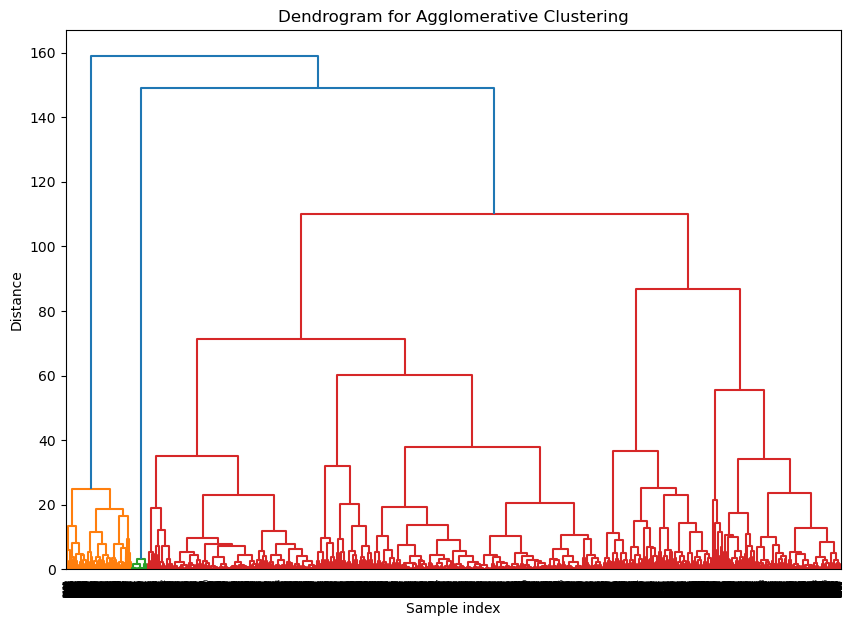


Predicted Driving Style for each Vehicle at each Time:
     Vehicle_ID              Global_Time predicted_driving_style
53            1  2005-06-15 08:19:36.900              Aggressive
167           2  2005-06-15 08:04:52.400              Aggressive
226           2  2005-06-15 08:19:39.600              Aggressive
327           3  2005-06-15 08:05:05.400                Balanced
355           3  2005-06-15 08:05:28.800              Aggressive
Silhouette Score: 0.5661

Driving Style Counts:
Class 0: 8947 samples
Class 1: 843 samples
Class 2: 210 samples


In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score


random_seed = 42

file_path = r'D:\UoM\DATA72002\Data\5Yichangjiashi.csv'
df = pd.read_csv(file_path)

# Speed classification
def categorize_speed(row):
    if row['v_Class'] == 1: 
        if row['v_Vel'] > 75:
            return 'High Speed'
        elif row['v_Vel'] > 45:
            return 'Medium Speed'
        else:
            return 'Low Speed'
    elif row['v_Class'] == 2: 
        if row['v_Vel'] > 75:
            return 'High Speed'
        elif row['v_Vel'] > 45:
            return 'Medium Speed'
        else:
            return 'Low Speed'
    elif row['v_Class'] == 3: 
        if row['v_Vel'] > 65:
            return 'High Speed'
        elif row['v_Vel'] > 40:
            return 'Medium Speed'
        else:
            return 'Low Speed'

# Apply speed classification
df['speed_category'] = df.apply(categorize_speed, axis=1)

# Acceleration classification
def categorize_acceleration(row):
    if row['v_Class'] == 1: 
        if row['v_Acc'] > 1.6:
            return 'High Acceleration'
        elif row['v_Acc'] >= 0.8:
            return 'Medium Acceleration'
        else:
            return 'Low Acceleration'
    elif row['v_Class'] == 2: 
        if row['v_Acc'] > 1.2:
            return 'High Acceleration'
        elif row['v_Acc'] >= 0.6:
            return 'Medium Acceleration'
        else:
            return 'Low Acceleration'
    elif row['v_Class'] == 3: 
        if row['v_Acc'] > 0.8:
            return 'High Acceleration'
        elif row['v_Acc'] >= 0.4:
            return 'Medium Acceleration'
        else:
            return 'Low Acceleration'

# Apply acceleration classification
df['acceleration_category'] = df.apply(categorize_acceleration, axis=1)

# Space headway and time headway classification
def categorize_headway(row):
    if row['Space_Headway'] <= 30:
        return 'Very Close'
    elif 30 < row['Space_Headway'] <= 100:
        return 'Normal Distance'
    else:
        return 'Far Distance'

def categorize_time_headway(row):
    if row['Time_Headway'] < 3:
        return 'Very Close'
    elif 3 <= row['Time_Headway'] <= 5:
        return 'Normal Distance'
    else:
        return 'Far Distance'

# Apply space headway and time headway classification
df['headway_category'] = df.apply(categorize_headway, axis=1)
df['time_headway_category'] = df.apply(categorize_time_headway, axis=1)

# Feature selection
features = ['v_Vel', 'v_Acc', 'Space_Headway', 'Time_Headway', 'is_abnormal_driving']

# Feature standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

# Randomly select 10,000 samples
df_sample = df.sample(n=10000, random_state=random_seed)  
X_sample = df_sample[features]

# Standardize sample data
X_sample_scaled = scaler.fit_transform(X_sample)
Z = linkage(X_sample_scaled, method='ward') 

# Plot dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title('Dendrogram for Agglomerative Clustering')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

agg_clustering = AgglomerativeClustering(n_clusters=3, linkage='ward')
cluster_labels = agg_clustering.fit_predict(X_sample_scaled)

df_sample.loc[:, 'driving_style'] = cluster_labels

# Output hierarchical clustering results
df_sample['predicted_driving_style'] = df_sample['driving_style'].map({0: 'Aggressive', 1: 'Balanced', 2: 'Conservative'})

# Output results
driving_style_predictions = df_sample[['Vehicle_ID', 'Global_Time', 'predicted_driving_style']]
driving_style_predictions = driving_style_predictions.sort_values(by=['Vehicle_ID', 'Global_Time'])

print("\nPredicted Driving Style for each Vehicle at each Time:")
print(driving_style_predictions.head())

# Evaluate clustering effectiveness
sil_score = silhouette_score(X_sample_scaled, df_sample['driving_style'])
print(f"Silhouette Score: {sil_score:.4f}")
driving_style_counts = df_sample['driving_style'].value_counts()

# Output count for each category
print("\nDriving Style Counts:")
for label, count in driving_style_counts.items():
    print(f"Class {label}: {count} samples")

In [17]:
import pandas as pd

# Read file with driving styles
file_path = r'D:\UoM\DATA72002\Data\5Yichangjiashi_with_style.csv'
df = pd.read_csv(file_path)

# Ensure these columns exist
assert 'is_abnormal_driving' in df.columns, "Missing is_abnormal_driving column"
assert 'driving_style' in df.columns, "Missing driving_style column"

style_counts = df.groupby(['is_abnormal_driving', 'driving_style']).size().unstack(fill_value=0)
style_ratios = style_counts.div(style_counts.sum(axis=1), axis=0) * 100

print("Counts by category:")
print(style_counts)
print("\nRatios by category (%):")
print(style_ratios.round(2))

# Save to files
style_counts.to_csv(r'D:\UoM\DATA72002\Data\style_counts_by_abnormal.csv')
style_ratios.to_csv(r'D:\UoM\DATA72002\Data\style_ratios_by_abnormal.csv')
print("\nStatistical results saved to CSV files.")

Counts by category:
driving_style             0       1      2
is_abnormal_driving                       
0                    344160  143725  29881
1                     10509   17092  19030

Ratios by category (%):
driving_style            0      1      2
is_abnormal_driving                     
0                    66.47  27.76   5.77
1                    22.54  36.65  40.81

Statistical results saved to CSV files.
